**Calcolo del gradiente con più direzioni**

 - In questo caso dobbiamo, per ogni time-step, calcolare il gradiente scegliendo più direzioni. La cosa migliore sarebbe quella di fare una funzione (guarda Appendix 1)

 - Una volta visto che funziona, proverei a riprodurre un grafico tipo quello di DOODGE per logistic regression mnist con SGD. In particolare plottiamo accuracy in ordinata e epoch in ascissa e facciamo più curve: 1 curva rappresenta SGD con gradiente calcolato con 1 direzione, poi 4 curve rappresentanti SGD con gradiente calcolato con 5, 10, 20, 40 direzioni, ed una curva rappresentante SGD con gradiente calcolato con backpropagation. Per questi test learning rate fisso a quello che abbiamo, i.e. 1e-4.

In [9]:
import jax 
import jax.numpy as jnp
from veni.net import *
from veni.functiontools import *
from veni.function import *
from veni.utils import * 
from torchvision.datasets import MNIST

jax.config.update('jax_platform_name','cpu')

dspath = '../datasets'
batch_size = 24
num_epochs = 5 
n_targets = 10
step_size = 1e-4

s0 = 1e-4



key = jax.random.PRNGKey(111111)

logging_freq = 200

class tf(object):
    def __call__(self, pic):
        return ( np.array(np.ravel(pic), dtype=jnp.float32)/ 255. - 0.5 ) * 2

print(f"Loading into/from path {dspath}")
train_dataset = MNIST(dspath, train = True, download= True, transform= tf())

n_train = train_dataset.data.shape[0]
train_generator = NumpyLoader(train_dataset, batch_size= batch_size )


test_dataset = MNIST(dspath, train = False,download= True, transform= tf() )

n_test = train_dataset.data.shape[0]
test_generator = NumpyLoader(test_dataset, batch_size= batch_size )
print("Loaded")

Loading into/from path ../datasets
Loaded


In [10]:
class LogisticRegressor(Module):
    def __init__(self):
        self.layers = Sequential([
            Linear(28*28, 10, key),
            Sigmoid()
        ])

        self.params = self.layers.generate_parameters()
    
    def forward(self,x,params):
        return self.layers(x,params)

In [11]:
class mlp(Module):
    def __init__(self):
        self.layers = Sequential([
            Linear(28*28, 1024, key),
            ReLU(),
            Linear(1024, 10, key),
            Softmax()
        ])

        self.params = self.layers.generate_parameters()
    
    def forward(self,x,params):
        return self.layers(x,params)

In [12]:
model = LogisticRegressor()

def logisticLoss(y,y_hat):
    l1 = y*jnp.log(y_hat)
    l2 = (1-y)*jnp.log(1 - y_hat)
    l = -jnp.sum(l1 + l2)
    return l/y.shape[0]

def sample_random_direction(params, normalize = False):
    global key
    v_shaped = []
    for w, b in params:
        key, subkey = random.split(key)
        v_w = random.normal(key, shape=w.shape)
        v_b = random.normal(subkey, shape=b.shape)
        if normalize:
            v_shaped.append((v_w/jnp.linalg.norm(v_w), v_b/jnp.linalg.norm(v_b)))
        else:
            v_shaped.append((v_w,v_b))
    return v_shaped


def update_params_list(p,g,scale = 1.):
    return [ (w - dw*scale, b - db*scale) for (w,b), (dw,db) in zip(p,g)]

def accuracy(y,y_hat):
    n = y.shape[0]
    y = jnp.argmax(y, axis = 1)
    y_hat = jnp.argmax(y_hat, axis = 1)

    return jnp.sum(y == y_hat)/n

def train_loop(model, train_generator, validation_generator, loss, nepochs, batchIteration, lr, log_every_n_batches):  
    params = model.params
    global key
    train_loss = [] 
    validation_loss = [] 

    train_acc = []
    validation_acc = []

    def lossFn(params, x, y):
        y_hat = model(x,params)
        return loss(y,y_hat)

    for epoch in range(nepochs):
        print(f"--- Epoch : {epoch} ---")
        l = 0
        a = 0
        print(f"\t Training")
        for i, (x,y) in enumerate(train_generator):
            key = jax.random.split(key)
            one_hot_y = one_hot(y,n_targets)
            params = batchIteration(params,x,one_hot_y,lossFn, lr)
            y_hat = model(x, params)
            l += loss(one_hot_y,y_hat)
            a += accuracy(one_hot_y,y_hat)

            if i % log_every_n_batches == (log_every_n_batches - 1):
                train_loss.append([epoch,i,float(l)/log_every_n_batches])
                train_acc.append([epoch,i,float(a)/log_every_n_batches])
                l = 0
                a = 0

                print(f"\t l: {train_loss[-1]}")
                print(f"\t a: {train_acc[-1]}")

        l = 0
        a = 0
        
        for i, (x,y) in enumerate(validation_generator):
            one_hot_y = one_hot(y,n_targets)
            y_hat = model(x,params)
            l += loss(one_hot_y,y_hat)
            a += accuracy(one_hot_y,y_hat)

        validation_loss.append([epoch,i,float(l)/ i])
        validation_acc.append([epoch,i,float(a)/ i])
        print(f"\t Validation")
        print(f"\t l: {validation_loss[-1]}")
        print(f"\t a: {validation_acc[-1]}")



    return [train_loss, train_acc, validation_loss, validation_acc]

def bwd_train_batch(params, x, y, lossFn, lr):
    grad = jax.grad(lossFn)(params,x,y)
    params = update_params_list(params,grad, lr)
    return params

def single_fwd_train_batch(params,x,y,lossFn,lr):
    global key
    key = jax.random.split(key)
    v = sample_random_direction(params, normalize=False)
    _, j = jax.jvp(lambda p: lossFn(p,x,y), (params, ), (v,))
    params = update_params_list(params, v, j*lr)
    return params
    


In [7]:
m = LogisticRegressor()
values = train_loop(m,train_generator, test_generator, logisticLoss, 1, single_fwd_train_batch, 1e-4, 200)

--- Epoch : 0 ---
	 Training
	 l: [0, 199, 5.516746215820312]
	 a: [0, 199, 0.105390625]
	 l: [0, 399, 3.6201287841796876]
	 a: [0, 399, 0.145703125]
	 l: [0, 599, 3.42521240234375]
	 a: [0, 599, 0.158671875]
	 l: [0, 799, 3.3166775512695312]
	 a: [0, 799, 0.183359375]
	 Validation
	 l: [0, 156, 2.5286004638671873]
	 a: [0, 156, 0.171796875]


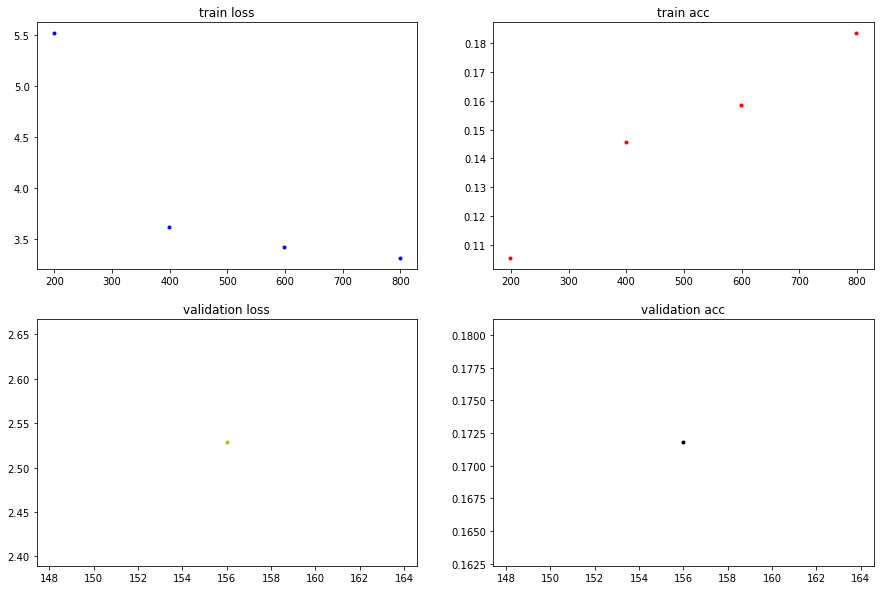

In [8]:
import matplotlib.pyplot as plt
def graph_all(values, btrain, btest, title = 'Title'):
    train_loss = values[0]
    train_loss = np.array([[l[0]*btrain + l[1], l[2]] for l in train_loss])

    train_acc = values[1]
    train_acc = np.array([[l[0]*btrain + l[1], l[2]] for l in train_acc])
    
    validation_loss = values[2]
    validation_loss = np.array([[l[0]*btest + l[1], l[2]] for l in validation_loss])

    validation_acc = values[3]
    validation_acc = np.array([[l[0]*btest + l[1], l[2]] for l in validation_acc])

    plt.figure(figsize= (15,10))
    plt.title(title)
    plt.subplot(2,2,1)
    plt.title("train loss")
    plt.plot(train_loss[:,0], train_loss[:,1], 'b.')


    plt.subplot(2,2,2)
    plt.title("train acc")
    plt.plot(train_acc[:,0], train_acc[:,1], 'r.')

    plt.subplot(2,2,3)
    plt.title("validation loss")
    plt.plot(validation_loss[:,0], validation_loss[:,1], 'y.')


    plt.subplot(2,2,4)
    plt.title("validation acc")
    plt.plot(validation_acc[:,0], validation_acc[:,1], 'k.')
graph_all(values, btrain = n_train // batch_size, btest = n_test // batch_size)

In [15]:
def multiple_fwd_train_batch(params,x,y,lossFn,lr, dirs ):
    global key
    for i in range(dirs):
        key, _ = jax.random.split(key)
        v = sample_random_direction(params, normalize= False)
        _, j = jax.jvp(lambda p: lossFn(p, x, y), (params, ), (v,))
        grad_now = [(j * dw, j * db) for (dw, db) in v]

        if i == 0:
            grad = grad_now

        elif i > 0:
            grad = [(dw + dw_prev, db + db_prev)
                           for (dw, db), (dw_prev, db_prev) in zip(grad_now, grad)]


    if dirs != 1:
        grad = [(dw / dirs, db / dirs) for (dw, db) in grad]

    params = update_params_list(params,grad,lr) 
    return params 


#passare ognuna di queste al training loop per fare il confronto con multiple direzioni

m5_fwd_train_batch = lambda params, x, y, lossFn, lr: multiple_fwd_train_batch(params, x, y, lossFn, lr, 5)
m10_fwd_train_batch = lambda params, x, y, lossFn, lr: multiple_fwd_train_batch(params, x, y, lossFn, lr, 10)
m20_fwd_train_batch = lambda params, x, y, lossFn, lr: multiple_fwd_train_batch(params, x, y, lossFn, lr, 20)
m40_fwd_train_batch = lambda params, x, y, lossFn, lr: multiple_fwd_train_batch(params, x, y, lossFn, lr, 40)

In [11]:
import pickle

m = LogisticRegressor()
values_5 = train_loop(m,train_generator, test_generator, logisticLoss, 10, m5_fwd_train_batch, 1e-4, 200)
with open("../v5.pk",'wb') as f:
    pickle.dump(values_5, f)
m = LogisticRegressor()


values_10 = train_loop(m,train_generator, test_generator, logisticLoss, 10, m10_fwd_train_batch, 1e-4, 200)
with open("../v10.pk",'wb') as f:
    pickle.dump(values_10, f)


m = LogisticRegressor()
values_20 = train_loop(m,train_generator, test_generator, logisticLoss, 10, m20_fwd_train_batch, 1e-4, 200)
with open("../v20.pk",'wb') as f:
    pickle.dump(values_20, f)


m = LogisticRegressor()
values_40 = train_loop(m,train_generator, test_generator, logisticLoss, 10, m40_fwd_train_batch, 1e-4, 200)
with open("../v40.pk",'wb') as f:
    pickle.dump(values_40, f)


--- Epoch : 0 ---
	 Training
	 l: [0, 199, 5.0870599365234375]
	 a: [0, 199, 0.096484375]
	 l: [0, 399, 3.512740478515625]
	 a: [0, 399, 0.130859375]
	 l: [0, 599, 3.3507232666015625]
	 a: [0, 599, 0.161015625]
	 l: [0, 799, 3.248712463378906]
	 a: [0, 799, 0.1990625]
	 Validation
	 l: [0, 156, 2.4795372009277346]
	 a: [0, 156, 0.181328125]
--- Epoch : 1 ---
	 Training
	 l: [1, 199, 3.122544250488281]
	 a: [1, 199, 0.240703125]
	 l: [1, 399, 3.0541763305664062]
	 a: [1, 399, 0.277421875]
	 l: [1, 599, 2.9861376953125]
	 a: [1, 599, 0.293671875]
	 l: [1, 799, 2.9070098876953123]
	 a: [1, 799, 0.328515625]
	 Validation
	 l: [1, 156, 2.2140623474121095]
	 a: [1, 156, 0.28921875]
--- Epoch : 2 ---
	 Training
	 l: [2, 199, 2.7971810913085937]
	 a: [2, 199, 0.3790625]
	 l: [2, 399, 2.757724609375]
	 a: [2, 399, 0.40375]
	 l: [2, 599, 2.714082946777344]
	 a: [2, 599, 0.41859375]
	 l: [2, 799, 2.6520755004882814]
	 a: [2, 799, 0.44390625]
	 Validation
	 l: [2, 156, 2.0173956298828126]
	 a: [2,

In [18]:
def params_norm(p):
    norm = 0
    for  w, b  in p:
        norm += jnp.linalg.norm(b)**2 + jnp.linalg.norm(w)**2

    return norm ** 0.5

import pickle

num_epochs = 18
m = LogisticRegressor()
vals = train_loop(m,train_generator, test_generator, logisticLoss, num_epochs, bwd_train_batch, 1e-4, 200)
with open(f"../logs/r1_b",'wb') as f:
    pickle.dump(vals, f)

for d in [1, 10, 50, 100]:

    print(f"Training with {d} directions \n \n")

    d_fwd_train_batch = lambda params, x, y, lossFn, lr: multiple_fwd_train_batch(params, x, y, lossFn, lr, d)
    
    m = LogisticRegressor()
    vals = train_loop(m,train_generator, test_generator, logisticLoss, num_epochs, d_fwd_train_batch, 1e-4, 200)
    with open(f"../logs/r1_{d}",'wb') as f:
        pickle.dump(vals, f)


--- Epoch : 0 ---
	 Training
	 l: [0, 199, 4.500812683105469]
	 a: [0, 199, 0.09208335876464843]
	 l: [0, 399, 3.4351815795898437]
	 a: [0, 399, 0.13187503814697266]
	 l: [0, 599, 3.3024258422851562]
	 a: [0, 599, 0.16958337783813476]
	 l: [0, 799, 3.2205859375]
	 a: [0, 799, 0.201875]
	 l: [0, 999, 3.143376770019531]
	 a: [0, 999, 0.241875057220459]
	 l: [0, 1199, 3.0808786010742186]
	 a: [0, 1199, 0.26187503814697266]
	 l: [0, 1399, 3.0037481689453127]
	 a: [0, 1399, 0.28687492370605466]
	 l: [0, 1599, 2.9395986938476564]
	 a: [0, 1599, 0.32645828247070313]
	 l: [0, 1799, 2.8847918701171875]
	 a: [0, 1799, 0.36270835876464846]
	 l: [0, 1999, 2.8249322509765626]
	 a: [0, 1999, 0.37375003814697266]
	 l: [0, 2199, 2.7455023193359374]
	 a: [0, 2199, 0.4131249237060547]
	 l: [0, 2399, 2.684312744140625]
	 a: [0, 2399, 0.45645843505859374]
	 Validation
	 l: [0, 416, 5.46547119140625]
	 a: [0, 416, 0.9997917938232422]
--- Epoch : 1 ---
	 Training
	 l: [1, 199, 2.6077838134765625]
	 a: [1, 1

KeyboardInterrupt: 